In [187]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import importlib

In [188]:
# for debug
import jpeg_table
importlib.reload(jpeg_table)

# テーブル読み込み
TBL_L_Q = jpeg_table.table_luminance_quantization
TBL_C_Q = jpeg_table.table_chrominance_quantization
TBL_L_DC = jpeg_table.table_luminance_dc
TBL_C_DC = jpeg_table.table_chrominance_dc
TBL_L_AC = jpeg_table.table_luminance_dc
TBL_C_AC = jpeg_table.table_chrominance_ac
TBL_DCT = jpeg_table.table_dct
TBL_IDCT = jpeg_table.table_idct

In [189]:
R = np.ndarray((8))
for i in range(8):
    R[i] = np.cos(i / 16.0 * np.pi) * np.sqrt(2.0)
INVSQRT2 = 1.0 / np.sqrt(2.0)

def llm_dct_8(x):
    y = np.ndarray((8))   
    c1 = x[0]; c2 = x[7]; t0 = c1 + c2; t7 = c1 - c2
    c1 = x[1]; c2 = x[6]; t1 = c1 + c2; t6 = c1 - c2
    c1 = x[2]; c2 = x[5]; t2 = c1 + c2; t5 = c1 - c2
    c1 = x[3]; c2 = x[4]; t3 = c1 + c2; t4 = c1 - c2
    c0 = t0 + t3; c3 = t0 - t3
    c1 = t1 + t2; c2 = t1 - t2
    y[0] = c0 + c1
    y[4] = c0 - c1
    y[2] = c2 * R[6] + c3 * R[2]
    y[6] = c3 * R[6] - c2 * R[2]
    c3 = t4 * R[3] + t7 * R[5]
    c0 = t7 * R[3] - t4 * R[5]
    c2 = t5 * R[1] + t6 * R[7]
    c1 = t6 * R[1] - t5 * R[7]
    y[5] = c3 - c1; y[3] = c0 - c2
    c0 = (c0 + c2) * INVSQRT2
    c3 = (c3 + c1) * INVSQRT2
    y[1] = c0 + c3; y[7] = c0 - c3
    for i in range(8):
        y[i] *= INVSQRT2 * 0.5
    return y

def llm_dct_8x8(src):
    dst = np.ndarray((8, 8))
    for i in range(8):
        dst[i, :] = llm_dct_8(src[i, :])
    for i in range(8):
        dst[:, i] = llm_dct_8(dst[:, i])
    return dst

def calc_llm_dct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            dst[yi:yi+8, xi:xi+8] = llm_dct_8x8(src[yi:yi+8, xi:xi+8])
    return dst



def llm_idct_8(y):
    x = np.ndarray((8))
    z0 = y[1] + y[7]; z1 = y[3] + y[5]; z2 = y[3] + y[7]; z3 = y[1] + y[5]
    z4 = (z0 + z1) * R[3]
    z0 = z0 * (-R[3] + R[7])
    z1 = z1 * (-R[3] - R[1])
    z2 = z2 * (-R[3] - R[5]) + z4
    z3 = z3 * (-R[3] + R[5]) + z4
    b3 = y[7] * (-R[1] + R[3] + R[5] - R[7]) + z0 + z2
    b2 = y[5] * ( R[1] + R[3] - R[5] + R[7]) + z1 + z3
    b1 = y[3] * ( R[1] + R[3] + R[5] - R[7]) + z1 + z2
    b0 = y[1] * ( R[1] + R[3] - R[5] - R[7]) + z0 + z3
    z4 = (y[2] + y[6]) * R[6]
    z0 = y[0] + y[4]; z1 = y[0] - y[4]
    z2 = z4 - y[6] * (R[2] + R[6])
    z3 = z4 + y[2] * (R[2] - R[6])
    a0 = z0 + z3; a3 = z0 - z3
    a1 = z1 + z2; a2 = z1 - z2
    x[0] = a0 + b0; x[7] = a0 - b0
    x[1] = a1 + b1; x[6] = a1 - b1
    x[2] = a2 + b2; x[5] = a2 - b2
    x[3] = a3 + b3; x[4] = a3 - b3
    for i in range(8):
        x[i] *= INVSQRT2 * 0.5
    return x

def llm_idct_8x8(src):
    dst = np.ndarray((8, 8))
    for i in range(8):
        dst[i, :] = llm_idct_8(src[i, :])
    for i in range(8):
        dst[:, i] = llm_idct_8(dst[:, i])
    return dst

def calc_llm_idct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            dst[yi:yi+8, xi:xi+8] = llm_idct_8x8(src[yi:yi+8, xi:xi+8])
    return dst

In [190]:
def calc_dct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            for v in range(8):
                for u in range(8):
                    dst[v+yi, u+xi] = np.sum(src[yi:yi+8, xi:xi+8] * TBL_DCT[v, u])
    return dst

def calc_idct(src):
    assert(len(src.shape) == 2)
    w = src.shape[1]
    h = src.shape[0]
    assert(w % 8 == 0)
    assert(h % 8 == 0)
    dst = np.zeros((h, w))
    for yi in range(0, h, 8):
        for xi in range(0, w, 8):
            for y in range(8):
                for x in range(8):
                    dst[y+yi, x+xi] = np.sum(src[yi:yi+8, xi:xi+8] * TBL_IDCT[y, x])
    return dst

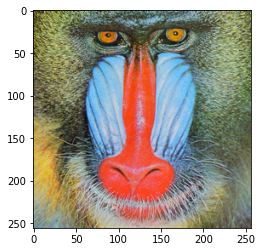

In [191]:
img_src = cv2.imread("Mandrill.bmp")
w = img_src.shape[1]
h = img_src.shape[0]
plt.imshow(img_src[:,:,::-1])

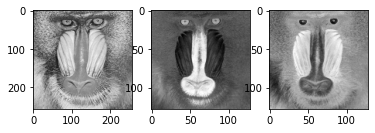

In [192]:
# YCbCr化 (色相は縮小)
img_ycrcb = cv2.cvtColor(img_src, cv2.COLOR_BGR2YCrCb)
img_y = img_ycrcb[:,:,0]
img_cr = cv2.resize(img_ycrcb[:,:,1], (w//2, h//2))
img_cb = cv2.resize(img_ycrcb[:,:,2], (w//2, h//2))

# 表示
plt.subplot(131)
plt.imshow(img_y, 'gray')
plt.subplot(132)
plt.imshow(img_cr, 'gray')
plt.subplot(133)
plt.imshow(img_cb, 'gray')

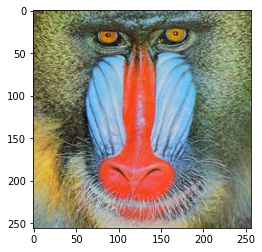

In [193]:
# dct
dct_y = calc_llm_dct(img_y.astype(np.float32) - 128)
dct_cr = calc_llm_dct(img_cr.astype(np.float32) - 128)
dct_cb = calc_llm_dct(img_cb.astype(np.float32) - 128)

# test
if True:
    # 戻るかチェック
    tmp_y = np.clip(calc_llm_idct(dct_y) + 128, 0, 255).astype(np.uint8)
    tmp_cr = np.clip(calc_llm_idct(dct_cr) + 128, 0, 255).astype(np.uint8)
    tmp_cb = np.clip(calc_llm_idct(dct_cb) + 128, 0, 255).astype(np.uint8)
    tmp_cr = cv2.resize(tmp_cr, (w, h))
    tmp_cb = cv2.resize(tmp_cb, (w, h))
    tmp_ycrcb = cv2.merge([tmp_y, tmp_cr, tmp_cb])
    tmp_rgb = cv2.cvtColor(tmp_ycrcb, cv2.COLOR_YCrCb2BGR)
    plt.imshow(tmp_rgb[:,:,::-1])

In [194]:
# 量子化してみる
for yi in range(0, h, 8):
    for xi in range(0, w, 8):
      dct_y[yi:yi+8, xi:xi+8] = np.round(dct_y[yi:yi+8, xi:xi+8] / TBL_L_Q).astype(np.int32)
#      dct_y[yi:yi+8, xi:xi+8] = np.floor(dct_y[yi:yi+8, xi:xi+8] / TBL_L_Q).astype(np.int32)
for yi in range(0, h//2, 8):
    for xi in range(0, w//2, 8):
       dct_cr[yi:yi+8, xi:xi+8] = np.round(dct_cr[yi:yi+8, xi:xi+8] / TBL_C_Q).astype(np.int32)
       dct_cb[yi:yi+8, xi:xi+8] = np.round(dct_cb[yi:yi+8, xi:xi+8] / TBL_C_Q).astype(np.int32)
#      dct_cr[yi:yi+8, xi:xi+8] = np.floor(dct_cr[yi:yi+8, xi:xi+8] / TBL_C_Q).astype(np.int32)
#      dct_cb[yi:yi+8, xi:xi+8] = np.floor(dct_cb[yi:yi+8, xi:xi+8] / TBL_C_Q).astype(np.int32)

In [195]:
# 逆量子化してみる
for yi in range(0, h, 8):
    for xi in range(0, w, 8):
        dct_y[yi:yi+8, xi:xi+8] *= TBL_L_Q
for yi in range(0, h//2, 8):
    for xi in range(0, w//2, 8):
        dct_cr[yi:yi+8, xi:xi+8] *= TBL_C_Q
        dct_cb[yi:yi+8, xi:xi+8] *= TBL_C_Q

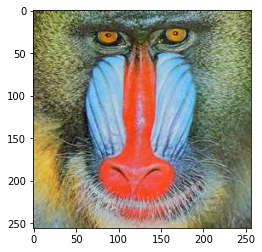

In [196]:
# 逆DCT
idct_y = np.clip(calc_llm_idct(dct_y) + 128, 0, 255).astype(np.uint8)
idct_cr = np.clip(calc_llm_idct(dct_cr) + 128, 0, 255).astype(np.uint8)
idct_cb = np.clip(calc_llm_idct(dct_cb) + 128, 0, 255).astype(np.uint8)

# 色相をリサイズ
idct_cr = cv2.resize(idct_cr, (w, h))
idct_cb = cv2.resize(idct_cb, (w, h))

# 表示
idct_ycrcb = cv2.merge([idct_y, idct_cr, idct_cb])
idct_rgb = cv2.cvtColor(idct_ycrcb, cv2.COLOR_YCrCb2BGR)
plt.imshow(idct_rgb[:,:,::-1])

In [197]:
tbl_zigzag = [
    [ 0,  1,  5,  6, 14, 15, 27, 28],
    [ 2,  4,  7, 13, 16, 26, 29, 42],
    [ 3,  8, 12, 17, 25, 30, 41, 43],
    [ 9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63],
]


def make_zigzag():
    a = []
    p = []
    for y in range(8):
        for x in range(8):
            a.append(tbl_zigzag[y][x])
            p.append((x, y))
    a = np.array(a)
    p = np.array(p)
    return p[np.argsort(a)]


table_zigzag = make_zigzag()